In [91]:
%matplotlib inline
import pandas as pd
import os
import re
from Bio import SeqIO
import pysam
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SearchIO
from pybedtools import BedTool

In [78]:
working_dir = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/blastp_on_p'
p_evalue = 1e-5
g_evalue = 1e-10
n_threads = 6
p_contigs = 'Pst_104E_v12_p_ctg.fa'
h_contigs = 'Pst_104E_v12_h_ctg.fa'
p_key = p_contigs.split('.')[0]
h_key = h_contigs.split('.')[0]

os.chdir(working_dir)

In [18]:
def blast_outfmt6_to_bed(x):
    blast_fo = open(x, 'r')
    blast_lines = blast_fo.readlines()
    bed_file_name = x + '.bed'
    bed_fo = open(bed_file_name, 'w+')
    for l in blast_lines:
        content = l.split('\t')
        if int(content[8]) - int(content[9]) < 1:
            print(content[1], int(content[8]) -1, content[9], content[0], content[10], "+", sep="\t", file=bed_fo) 
        else:
            print(content[1], int(content[9]) -1, content[8],  content[0], content[10], "-", sep = "\t", file=bed_fo)
    blast_fo.close()
    bed_fo.close()

In [50]:
def pwh_filter (x):
    p_contig = x.split('.')[2]
    if p_contig in pwh_set:
        return 1
    else:
        return 0

In [57]:
def same_contig_blast(x,y):
    '''Function that checks if the blast hit in columne y is on the same contig as the the query sequence in
    column y.
    '''
    q_contig = x.split('.')[2].split('_')[1]
    hit_contig = y.split('_')[1]
    if q_contig == hit_contig:
        return True
    else:
        return False

In [72]:
def col_8_id(x):
    import re
    pattern = r'ID=([a-zA-Z0-9_.]*);'
    regex = re.compile(pattern)  
    m = regex.search(x)
    match = m.groups()[0].replace('TU', 'model')
    if match.startswith('cds.'):
        match = match[4:]
    if 'exon' in match:
        _list = match.split('.')
        match = '.'.join(_list[:-1])
    return match


In [7]:
#make databases and run protein blast
protein_fa = [x for x in os.listdir() if x.endswith('protein.fa')]
protein_fa.sort()
for fa in protein_fa:
    !makeblastdb -in {fa} -dbtype prot



Building a new DB, current time: 03/08/2017 10:26:59
New DB name:   /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/blastp_on_p/Pst_104E_v12_h_ctg.anno.protein.fa
New DB title:  Pst_104E_v12_h_ctg.anno.protein.fa
Sequence type: Protein
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 14321 sequences in 0.532387 seconds.


Building a new DB, current time: 03/08/2017 10:27:00
New DB name:   /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/blastp_on_p/Pst_104E_v12_p_ctg.anno.protein.fa
New DB title:  Pst_104E_v12_p_ctg.anno.protein.fa
Sequence type: Protein
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 15928 sequences in 0.625616 seconds.


In [34]:
contig_files = [x for x in os.listdir() if x.endswith('_ctg.fa')]
contig_files.sort()
for contigs in contig_files:
    !makeblastdb -in {contigs} -dbtype nucl



Building a new DB, current time: 03/08/2017 11:18:00
New DB name:   /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/blastp_on_p/Pst_104E_v12_h_ctg.fa
New DB title:  Pst_104E_v12_h_ctg.fa
Sequence type: Nucleotide
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 475 sequences in 0.892212 seconds.


Building a new DB, current time: 03/08/2017 11:18:01
New DB name:   /home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_104E_v12/blastp_on_p/Pst_104E_v12_p_ctg.fa
New DB title:  Pst_104E_v12_p_ctg.fa
Sequence type: Nucleotide
Keep Linkouts: T
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 156 sequences in 1.00498 seconds.


In [15]:
!blastp -query {protein_fa[0]} -db {protein_fa[1]} -outfmt 6 -evalue {p_evalue} -num_threads {n_threads} > {protein_fa[0].split('.')[0]}.on.{protein_fa[1].split('.')[0]}.outfmt6

In [16]:
!blastp -query {protein_fa[1]} -db {protein_fa[0]} -outfmt 6 -evalue {p_evalue} -num_threads {n_threads} > {protein_fa[1].split('.')[0]}.on.{protein_fa[0].split('.')[0]}.outfmt6

In [19]:
hit_df =''
outfmt6 = [x for x in os.listdir() if x.endswith('outfmt6') and 'on' in x]
outfmt6.sort()
print(outfmt6)
fa_files = protein_fa
fa_files.sort()
print(fa_files)

#The next block should pull in both the initial protein and the blast df.
#The initial protein should become a dataframe that contains proteins sequence name and length.
#This df should be merged with the blast df in a way that proteins without hit should get NA values. 
#Once this is done make two arrays with [p, h], sort this and compare, pull out everything that is identical, and lable it with a new column reverse blast Yes/No.
#Pull out YES and see if they are enriched/depelted in something. NOs need to be checked for high coverage in ph vs h/p mapping and levels of heterozycosity + h on p mapping mappings. 

#read in protein ids for p and h contigs and store names in a list in a dict with unique key id [first part of
#file name].
fa_protein_dict = {}
fa_protein_length_dict = {}
for file in fa_files:
    seq_list = []
    length_list =[]
    for seq in SeqIO.parse(open(file), 'fasta'):
        seq_list.append(seq.id)
        length_list.append(len(seq.seq))
    key_name = file.split('.')[0]
    fa_protein_dict[key_name] = seq_list
    fa_protein_length_dict[key_name] = dict(zip(seq_list, length_list))

#generate df dict of blast output and filter blast output
header = ['Query', 'Target', 'PctID', 'AlnLgth', 'NumMis', 'NumGap', 'StartQuery', 'StopQuery', 'StartTarget',\
              'StopTarget', 'e-value','BitScore']
outfmt6_dict ={} #contains the filtered values
outfmt6_dict_all = {} #contains the unfiltered blast hits e.g. low % identity and low query coverage
#match_dict = {} #get best hits in match_dict[p_protein] = h_protein
hit_df = pd.DataFrame(columns=['p_protein', 'h_protein'])
for outfile in outfmt6:
    key_name =  outfile.split('.')[0]
    df = ''
    df = pd.read_csv(outfile, header = None, names = header, sep='\t')
    #add the query length using to the df using the length dict generated before
    df["QLgth"] = df["Query"].apply(lambda x: fa_protein_length_dict[key_name][x]) 
    df["QCov"] = df['AlnLgth']/df['QLgth']*100 #calculate the % coverage for each querry
    outfmt6_dict_all[key_name] = df
    df = df[(df['QCov'] > 30) & (df['PctID'] > 50) ] #define paralogous as Query coverage > 30% and PctID > 50
    #this could be more dynamic and the outfmt of blast AlnLngthPct and they greater than 60%
    groups = df.groupby(by='Query')
    #now filter the dataframe by the smallest e-value for each group == Query
    df_filtered = groups.apply(lambda g: g[g['e-value'] == g['e-value'].min()]) 
    df_filtered = df_filtered.reset_index(drop=True)
    #in case there is a blast query that hits the same subject twice with the same minimal e-value
    df_filtered = df_filtered.drop_duplicates(subset=['Query', 'Target'], keep ='last')
    outfmt6_dict[key_name] = df_filtered
    if 'p_ctg' in key_name:
        df_filtered['h_protein'] = df_filtered['Target']
        df_filtered['p_protein'] = df_filtered['Query']
    if 'h_ctg' in key_name:
        df_filtered['h_protein'] = df_filtered['Query']
        df_filtered['p_protein'] = df_filtered['Target']
    hit_df = pd.concat([hit_df, df_filtered.loc[:, ['p_protein', 'h_protein']]])

#duplicates are besties as they are entered twice from both outfmt

bestie_df = hit_df[hit_df.duplicated(keep='first')]

bestie_df.to_csv(list(outfmt6_dict.keys())[0][:-6] + '.besties.txt', sep='\t', header=None, index=None)
bestie_df['p_protein'].to_csv(list(outfmt6_dict.keys())[0] + '.besties.txt', sep='\t', header=None, index=None)
bestie_df['h_protein'].to_csv(list(outfmt6_dict.keys())[1] + '.besties.txt', sep='\t', header=None, index=None)


#this is pulling out the no blast hits at all. Should be a subset of no_besties
no_hits ={}
for key in fa_protein_dict.keys():
    if 'p_' in key:
        no_hits[key] = set(fa_protein_dict[key]) - set(outfmt6_dict_all[key]['Query'].unique())
        pd.DataFrame(list(no_hits[key])).to_csv(key + '.p_proteins.no_blast_hit.txt', sep='\t', header=None, index=None)
    if 'h_' in key:
        no_hits[key] = set(fa_protein_dict[key]) - set(outfmt6_dict_all[key]['Query'].unique())
        pd.DataFrame(list(no_hits[key])).to_csv(key + '.h_proteins.no_blast_hit.txt', sep='\t', header=None, index=None)

no_hits_filtered ={}
for key in fa_protein_dict.keys():
    if 'p_' in key:
        no_hits_filtered[key] = set(fa_protein_dict[key]) - set(outfmt6_dict[key]['Query'].unique())
        pd.DataFrame(list(no_hits_filtered[key])).to_csv(key + '.p_proteins.no_filtered_blast_hit.txt', sep='\t', header=None, index=None)
    if 'h_' in key:
        no_hits_filtered[key] = set(fa_protein_dict[key]) - set(outfmt6_dict[key]['Query'].unique())
        pd.DataFrame(list(no_hits_filtered[key])).to_csv(key + '.h_proteins.no_filtered_blast_hit.txt', sep='\t', header=None, index=None)
        

#this is now pulling out the besties
no_bestie ={}
for key in fa_protein_dict.keys():
    if 'p_' in key:
        no_bestie[key] = set(fa_protein_dict[key]) - set(bestie_df['p_protein'])
        pd.DataFrame(list(no_bestie[key])).to_csv(key + '.p_proteins.no_besties.txt', sep='\t', header=None, index=None)
    if 'h_' in key:
        no_bestie[key] = set(fa_protein_dict[key]) - set(bestie_df['h_protein'])
        pd.DataFrame(list(no_bestie[key])).to_csv(key + '.h_proteins.no_besties.txt', sep='\t', header=None, index=None)        
        
_len_out = 0
_len_pro = 0
for x in fa_protein_dict.keys():
    _len_pro += len(fa_protein_dict[x])
    _len_out += len(no_bestie[x])
_len_out += (len(bestie_df))*2 - bestie_df.duplicated(subset="p_protein", keep='last').sum() \
- bestie_df.duplicated(subset="h_protein", keep='last').sum()
_len_out == _len_pro


['Pst_104E_v12_h_ctg.on.Pst_104E_v12_p_ctg.outfmt6', 'Pst_104E_v12_p_ctg.on.Pst_104E_v12_h_ctg.outfmt6']
['Pst_104E_v12_h_ctg.anno.protein.fa', 'Pst_104E_v12_p_ctg.anno.protein.fa']


True

In [20]:
_len_out = 0
_len_pro = 0
for x in fa_protein_dict.keys():
    _len_pro += len(fa_protein_dict[x])
    _len_out += len(no_bestie[x])
    print("Out of %i %i have no reciprocal blast hit for %s making it %.2f percent."%(len(fa_protein_dict[x]),len(no_bestie[x]),x, (len(no_bestie[x])/len(fa_protein_dict[x])*100) ))
    print("Out of %i %i have no blast hit at all for %s making it %.2f percent."%(len(fa_protein_dict[x]),len(no_hits[x]),x, (len(no_hits[x])/len(fa_protein_dict[x])*100) ))
    print("Out of %i %i have no blast hit after filtering by AlnLght and QCov for %s making it %.2f percent."%(len(fa_protein_dict[x]),len(no_hits_filtered[x]),x, (len(no_hits_filtered[x])/len(fa_protein_dict[x])*100) ))
_len_out += (len(bestie_df))*2 - bestie_df.duplicated(subset="p_protein", keep='last').sum() \
- bestie_df.duplicated(subset="h_protein", keep='last').sum()
_len_out == _len_pro

Out of 15928 4252 have no reciprocal blast hit for Pst_104E_v12_p_ctg making it 26.70 percent.
Out of 15928 1222 have no blast hit at all for Pst_104E_v12_p_ctg making it 7.67 percent.
Out of 15928 2121 have no blast hit after filtering by AlnLght and QCov for Pst_104E_v12_p_ctg making it 13.32 percent.
Out of 14321 2495 have no reciprocal blast hit for Pst_104E_v12_h_ctg making it 17.42 percent.
Out of 14321 333 have no blast hit at all for Pst_104E_v12_h_ctg making it 2.33 percent.
Out of 14321 541 have no blast hit after filtering by AlnLght and QCov for Pst_104E_v12_h_ctg making it 3.78 percent.


True

In [35]:
#now pull gene sequences for no-besties and do blast on the corresponding other haplotype

no_besties = [x for x in os.listdir(working_dir) if x.endswith('no_besties.txt')]
gene_files = [x for x in os.listdir(working_dir) if '.gene.' in x and '.fa' in x]
no_besties.sort()
gene_files.sort()
no_bestie_dict = {}

#simply pulls in the gene sequences of missing besties
for no_b, gene_file in zip(no_besties, gene_files):
    no_bestie_list = pd.read_csv(working_dir+'/'+no_b, header=None, sep='\t')[0].tolist()
    key = no_b.split('.')[0]
    no_bestie_dict[key] = no_bestie_list
    no_bestie_list = [x.replace('evm.model', 'evm.TU') for x in no_bestie_list]
    no_bestie_seq = []
    for seq in SeqIO.parse(open(working_dir +'/'+ gene_file), 'fasta'):
        if seq.id in no_bestie_list:
            no_bestie_seq.append(seq)
    out_f = os.path.join(working_dir, no_b[:-3].replace('protein', 'gene') + 'fa')
    f_handle = open(out_f,'w') #need to generate handle for writing and
    SeqIO.write(no_bestie_seq, f_handle, 'fasta')
    f_handle.close() #closing file afterwards again

gene_files_no_besties = [x for x in os.listdir(working_dir) if x.endswith('_genes.no_besties.fa')]
blast_db_nt = [x for x in os.listdir(working_dir) if x.endswith('_ctg.fa')]
gene_files_no_besties.sort()
blast_db_nt.sort()

os.chdir(working_dir)

print('blastn -db %s -query -%s > %s.outfmt6' %(blast_db_nt[1], gene_files_no_besties[0],gene_files_no_besties[0]))
!blastn -db {blast_db_nt[1]} -query {gene_files_no_besties[0]}  -outfmt 6 -evalue {g_evalue} -num_threads {n_threads} \
> {gene_files_no_besties[0]}.outfmt6


in_file =gene_files_no_besties[0]+'.outfmt6'
blast_outfmt6_to_bed(in_file)

print('blastn -db %s -query -%s > %s.outfmt6' %(blast_db_nt[0], gene_files_no_besties[1],gene_files_no_besties[1]))
!blastn -db {blast_db_nt[0]} -query {gene_files_no_besties[1]}  -outfmt 6 -evalue {g_evalue} -num_threads {n_threads} \
> {gene_files_no_besties[1]}.outfmt6


in_file =gene_files_no_besties[1]+'.outfmt6'
blast_outfmt6_to_bed(in_file)

blastn -db Pst_104E_v12_p_ctg.fa -query -Pst_104E_v12_h_ctg.h_genes.no_besties.fa > Pst_104E_v12_h_ctg.h_genes.no_besties.fa.outfmt6
blastn -db Pst_104E_v12_h_ctg.fa -query -Pst_104E_v12_p_ctg.p_genes.no_besties.fa > Pst_104E_v12_p_ctg.p_genes.no_besties.fa.outfmt6


In [38]:
#blast no_filtered_blast_hits genes against opposite haplotyp at the gene level

no_filtered_blast = [x for x in os.listdir(working_dir) if x.endswith('no_filtered_blast_hit.txt')]
gene_files = [x for x in os.listdir(working_dir) if '.gene.' in x and '.fa' in x]
no_filtered_blast.sort()
gene_files.sort()
no_filtered_blast_dict = {}
gene_files = gene_files[:2]

#simply pulls in the gene sequences of missing besties
for no_b, gene_file in zip(no_filtered_blast, gene_files):
    print(no_b)
    no_filtered_blast_list = pd.read_csv(working_dir+'/'+no_b, header=None, sep='\t')[0].tolist()
    key = no_b.split('.')[0]
    no_filtered_blast_dict[key] = no_filtered_blast_list
    no_filtered_blast_list = [x.replace('evm.model', 'evm.TU') for x in no_filtered_blast_list]
    no_filtered_blast_seq = []
    for seq in SeqIO.parse(open(working_dir + '/'+gene_file), 'fasta'):
        if seq.id in no_filtered_blast_list:
            no_filtered_blast_seq.append(seq)
    out_f = ''
    out_f = os.path.join(working_dir, no_b[:-3].replace('protein', 'gene') + 'fa')
    f_handle = open(out_f,'w') #need to generate handle for writing and
    SeqIO.write(no_filtered_blast_seq, f_handle, 'fasta')
    f_handle.close() #closing file afterwards again

gene_files_no_filtered_blast = [x for x in os.listdir(working_dir) if x.endswith('_genes.no_filtered_blast_hit.fa')]
blast_db_nt = [x for x in os.listdir(working_dir) if x.endswith('_ctg.fa')]
gene_files_no_filtered_blast.sort()
blast_db_nt.sort()


print('blastn -db %s -query -%s > %s.outfmt6' %(blast_db_nt[1], gene_files_no_filtered_blast[0],gene_files_no_filtered_blast[0]))
!blastn -db {blast_db_nt[1]} -query {gene_files_no_filtered_blast[0]}  -outfmt 6 -evalue {g_evalue} -num_threads {n_threads} \
> {gene_files_no_filtered_blast[0]}.outfmt6


in_file =gene_files_no_filtered_blast[0]+'.outfmt6'
blast_outfmt6_to_bed(in_file)

print('blastn -db %s -query -%s > %s.outfmt6' %(blast_db_nt[0], gene_files_no_filtered_blast[1],gene_files_no_filtered_blast[1]))
!blastn -db {blast_db_nt[0]} -query {gene_files_no_filtered_blast[1]}  -outfmt 6 -evalue {g_evalue} -num_threads {n_threads} \
> {gene_files_no_filtered_blast[1]}.outfmt6


in_file =gene_files_no_filtered_blast[1]+'.outfmt6'
blast_outfmt6_to_bed(in_file)

Pst_104E_v12_h_ctg.h_proteins.no_filtered_blast_hit.txt
Pst_104E_v12_p_ctg.p_proteins.no_filtered_blast_hit.txt
blastn -db Pst_104E_v12_p_ctg.fa -query -Pst_104E_v12_h_ctg.h_genes.no_filtered_blast_hit.fa > Pst_104E_v12_h_ctg.h_genes.no_filtered_blast_hit.fa.outfmt6
blastn -db Pst_104E_v12_h_ctg.fa -query -Pst_104E_v12_p_ctg.p_genes.no_filtered_blast_hit.fa > Pst_104E_v12_p_ctg.p_genes.no_filtered_blast_hit.fa.outfmt6


In [44]:
#make a dict of df out of the _genes.no_filtered_blast_hit.fa.outfmt6.bed files this can be used later on for
#summary purposes and such
nfb_gene_blast_bed_df_filtered = [x for x in os.listdir() if x.endswith('no_filtered_blast_hit.fa.outfmt6.bed')]
nfb_gene_blast_bed_df_filtered_dict = {}
for file in nfb_gene_blast_bed_df_filtered:
    key = ''
    key = file.split('.')[0]
    nfb_gene_blast_bed_df_filtered_dict[key] = pd.read_csv(file, header = None, sep='\t')
    print("%i no_fitered protein blast hits have a nt level blast hit for %s" %(len(nfb_gene_blast_bed_df_filtered_dict[key][3].unique()),key))

670 no_fitered protein blast hits have a nt level blast hit for Pst_104E_v12_p_ctg
441 no_fitered protein blast hits have a nt level blast hit for Pst_104E_v12_h_ctg


In [46]:
#here track what happens with the no_besties hit. Do they not have protein blast hits? How many of the no protein 
#blast hits have not gene blast hit?
#this needs to include some folder tracking of gene.no_besties.fa that hits nothing significant 
#no_bbb in - no_bbb out = no_hits at all
no_gene_hits = {}
no_besties_blast_nt_bed = [x for x in os.listdir() if x.endswith('no_besties.fa.outfmt6.bed')]
no_besties_blast_nt_bed.sort()
for no_bbb, protein_blast in zip(no_besties_blast_nt_bed,outfmt6):
    no_bbb_no_protein_blast_df =''
    no_bbb_df_header = ['Contig', 'start', 'end', 'blast_query', 'e-value', 'strand']
    no_bbb_df = pd.read_csv(working_dir+'/'+no_bbb, header=None, names=no_bbb_df_header,  sep='\t')
    protein_blast_df = pd.read_csv(working_dir+'/'+protein_blast, header=None, sep='\t')
    no_bbb_df['protein_id'] = no_bbb_df['blast_query'].str.replace('evm.TU', 'evm.model')
    #this below is most likely correct ignores the fact that some no_bbb genes might have hit nothing
    #at all on the gene level
    no_bbb_no_protein_blast_df = no_bbb_df[~no_bbb_df['protein_id'].isin(protein_blast_df[0])]
    #these are the no_besties that didn't hit anything at the gene level
    key =''
    key = no_bbb.split('.')[0]
    no_gene_hits[key] = set(no_bestie_dict[key]) - set(no_bbb_df['protein_id'].unique())
    pd.DataFrame(list(no_gene_hits[key])).to_csv(key + '.gene.no_genome_blast_hit.txt', sep='\t', header=None, index=None)
    blast_p_no_bestie =''
    blast_p_no_bestie = len(no_bbb_df[no_bbb_df['protein_id'].isin(protein_blast_df[0])]['blast_query'].unique())
    print('This %i out of %i no_besties of %s had a blast hit which was not RBH' % \
          (blast_p_no_bestie, len(no_bestie_dict[key]),no_bbb.split('.')[0]))
    print('This %i out of %i no_besties of %s have no blast hit gene vs. other haplome' % \
         (len(no_gene_hits[key]),len(no_bestie_dict[key]),no_bbb.split('.')[0]))
    print("No gene hits that have a protein hit", len(set(no_gene_hits[key])- set(no_hits[key])), key)
    groups = no_bbb_no_protein_blast_df.groupby(by='blast_query')
    #now filter the dataframe by the smallest e-value for each group == blast_hit
    df_filtered = groups.apply(lambda g: g[g['e-value'] == g['e-value'].min()])
    df_filtered = df_filtered.reset_index(drop=True)
    df_filtered.iloc[:,0:6].to_csv(working_dir+'/'+no_bbb[:-4]+'.filteredbesthits.bed', sep='\t', header=None, index=None)

This 2046 out of 2495 no_besties of Pst_104E_v12_h_ctg had a blast hit which was not RBH
This 170 out of 2495 no_besties of Pst_104E_v12_h_ctg have no blast hit gene vs. other haplome
No gene hits that have a protein hit 116 Pst_104E_v12_h_ctg
This 2162 out of 4252 no_besties of Pst_104E_v12_p_ctg had a blast hit which was not RBH
This 1687 out of 4252 no_besties of Pst_104E_v12_p_ctg have no blast hit gene vs. other haplome
No gene hits that have a protein hit 868 Pst_104E_v12_p_ctg


In [48]:
#all primary proteins no hit need to be split up into pwh and pwoh
p_contig_list = []
h_contig_list = []
for seq in SeqIO.parse(h_contigs, 'fasta'):
    h_contig_list.append(seq.id)
for seq in SeqIO.parse(p_contigs, 'fasta'):
    p_contig_list.append(seq.id)

In [49]:
pwh_set = set([x[0:11].replace('h','p') for x in h_contig_list])
pwoh_set = set(p_contig_list) - pwh_set
print("P_contigs with h_contig are %i and without %i" % (len(pwh_set), len(pwoh_set)))

P_contigs with h_contig are 99 and without 57


In [52]:

fa_protein_dict[p_key+'_pwh']= [x for x in fa_protein_dict[p_key] if x.split('.')[2] in pwh_set]
fa_protein_dict[p_key+'_pwoh']= [x for x in fa_protein_dict[p_key] if x.split('.')[2] in pwoh_set]
print(len(fa_protein_dict[p_key+'_pwh']), len(fa_protein_dict[p_key+'_pwoh']), len (fa_protein_dict[p_key]))


15303 625 15928


In [61]:
#filter and summarize the p results based on pwh and pwoh 
p_txt = [x for x in os.listdir(working_dir) if x.split('.')[0] == p_key and x.endswith('.txt')\
        and not 'pwh' in x and not 'pwoh' in x and not x.endswith('besties.txt')]
for x in p_txt:
    #print(x)
    df_p = pd.read_csv(x, header=None, sep='\t')
    #df_p.head()
    df_p['pwh'] = df_p[0].apply(pwh_filter)
    df_p[df_p['pwh'] == 1].to_csv(x[:-4]+'pwh.txt', sep ='\t', header=None, index=None)
    df_p[df_p['pwh'] == 0].to_csv(x[:-4]+'pwoh.txt', sep ='\t', header=None, index=None)
    print ('For pwh:')
    print('For this condition %s %i proteins out of %i (%.2f) are affected for pwh'% \
          (x, sum(df_p['pwh']),len(fa_protein_dict[p_key+'_pwh']), \
           sum(df_p['pwh'])/len(fa_protein_dict[p_key+'_pwh'])*100 ))
    print ('For pwoh:')
    print('For this condition %s %i proteins out of %i (%i) are affected for pwoh'% \
         (x, len(df_p['pwh']) - sum(df_p['pwh']),len(fa_protein_dict[p_key+'_pwoh']),\
        (len(df_p['pwh']) - sum(df_p['pwh']))/len(fa_protein_dict[p_key+'_pwoh'])*100 ))
     


len_pwh = 0
len_pwoh = 0
for seq in SeqIO.parse(p_contigs, 'fasta'):
    if seq.id in pwh_set:
        len_pwh = len_pwh + len(seq.seq)
    if seq.id in pwoh_set:
        len_pwoh = len_pwoh + len(seq.seq)
print("Lenght of pwoh %i, lenght of pwo %i, total length p %i" %(len_pwh,len_pwoh,len_pwh+len_pwoh ))

For pwh:
For this condition Pst_104E_v12_p_ctg.gene.no_genome_blast_hit.txt 1443 proteins out of 15303 (9.43) are affected for pwh
For pwoh:
For this condition Pst_104E_v12_p_ctg.gene.no_genome_blast_hit.txt 244 proteins out of 625 (39) are affected for pwoh
For pwh:
For this condition Pst_104E_v12_p_ctg.p_proteins.no_blast_hit.txt 1096 proteins out of 15303 (7.16) are affected for pwh
For pwoh:
For this condition Pst_104E_v12_p_ctg.p_proteins.no_blast_hit.txt 126 proteins out of 625 (20) are affected for pwoh
For pwh:
For this condition Pst_104E_v12_p_ctg.p_proteins.no_filtered_blast_hit.txt 1866 proteins out of 15303 (12.19) are affected for pwh
For pwoh:
For this condition Pst_104E_v12_p_ctg.p_proteins.no_filtered_blast_hit.txt 255 proteins out of 625 (40) are affected for pwoh
Lenght of pwoh 79770604, lenght of pwo 3585012, total length p 83355616


In [63]:
#get the best blast hit gene regions for each protein to do a exonerate alignment late on
nfb_gene_blast_bed = [x for x in os.listdir(working_dir) if x.endswith('no_filtered_blast_hit.fa.outfmt6.bed')]
nfb_gene_blast_bed.sort()
protein_dict_nfb_bhits = {}
protein_dict_nfb = {} #get a list of all proteins of nfb that don't have a hit when blasted at the gene level too
#get the fasta genome files
tmp_genome_files = [x for x in os.listdir() if x.endswith('_ctg.fa')]
protein_fa_files = protein_fa
for bed_file in nfb_gene_blast_bed:
    print('This %s is the current bed file being processed' % (bed_file))
    nfb_gene_blast_bed_df =''
    nfb_gene_blast_bed_df = pd.read_csv(bed_file, header=None, sep='\t' )
    #now add another column to the dateframe that stats if the hit and query are on the same contig
    nfb_gene_blast_bed_df['Same_contig'] = nfb_gene_blast_bed_df[3].combine(nfb_gene_blast_bed_df[0], func=same_contig_blast)
    #initialize some temporary df for filtering
    tmp_same_contig_df =''
    tmp_best_hits_df =''
    tmp_groups =''
    tmp_best_hits_filtered =''
    #get all blast hits that are on the same contig
    tmp_same_contig_df = nfb_gene_blast_bed_df[nfb_gene_blast_bed_df['Same_contig'] == True]
    #get the best remaining blast hit(s)
    tmp_best_hits_df = nfb_gene_blast_bed_df[nfb_gene_blast_bed_df['Same_contig'] == False].sort_values(by=[3,4])
    tmp_groups = tmp_best_hits_df.groupby(by=3)
    #now filter the dataframe by the smallest e-value for each group == Query/3
    tmp_best_hits_df_filtered = tmp_groups.apply(lambda g: g[g[4] == g[4].min()]) 
    tmp_best_hits_df_filtered = tmp_best_hits_df_filtered.reset_index(drop=True)
    nfb_gene_blast_bed_df_filtered = ''
    nfb_gene_blast_bed_df_filtered = pd.concat([tmp_best_hits_df_filtered, tmp_same_contig_df]).sort_values(by=[3,4]).reset_index(drop=True)
    #now get the loop through the df. pull out the protein sequences and corresponding hits. save them to new folders.
    #extend the script. 
    #get all the blasted sequences that had a hit == unique querries
    tmp_queries = ''
    tmp_queries = nfb_gene_blast_bed_df_filtered[3].unique()
    #get all the protein sequences in a dictionary with protein ID being the key and the values being a SeqIO object
    #get the fasta genome files
    tmp_genome_file = [x for x in tmp_genome_files if not x.startswith(bed_file.split('.')[0])][0]
    genome_fa = ''
    genome_fa = pysam.FastaFile(tmp_genome_file)
    tmp_queries_id = [x.replace('TU', 'model') for x in tmp_queries]
    tmp_protein_fa_file = [x for x in protein_fa_files if x.startswith(bed_file.split('.')[0])][0]
    for seq in SeqIO.parse(open(tmp_protein_fa_file), 'fasta'):
            if seq.id in tmp_queries_id:
                protein_dict_nfb[seq.id] = seq
    #add this tmp_protein_dict_nfb to the full protein dict to keep track
    #check why only one file gets processed.
    
    
    #make a dict that gets the blast hit sequences in +30kb each side for alignments of protein sequences on top of them. 
    #The value of this dict will be a list of SeqIO objects
    
    tmp_list = [] #tmp_list to save the SeqIO objects for the blast hits in
    print(len(tmp_queries))
    for query in tmp_queries:
        #print(query)
        tmp_list = []
        tmp_df = nfb_gene_blast_bed_df_filtered[nfb_gene_blast_bed_df_filtered[3] == query]
        #do groupby instead here on columns one. Take min of column 1 and max of column 2 as start/stop +-
        #this avoids to mess around with mutliple hits on the same contig
        tmp_hit = tmp_df[0].unique()
        for hit in tmp_hit:
            tmp_df_2 = tmp_df[tmp_df[0] == hit]
            start = tmp_df_2[1].min() - 30000
            if start < 1:
                start = 1
            end = tmp_df_2[2].max() + 30000
            seq = genome_fa.fetch(hit, start, end)
            seq_r = '' #initialize empty SeqIO record
            seq_id = hit + '_' + str(start) + '_' + str(end)
            seq_ob = Seq(seq)
            seq_ob.alphabet = 'fasta'
            seq_r = SeqRecord(seq_ob)
            seq_r.id = seq_id
            tmp_list.append(seq_r)
        protein_dict_nfb_bhits[query] = tmp_list

This Pst_104E_v12_h_ctg.h_genes.no_filtered_blast_hit.fa.outfmt6.bed is the current bed file being processed
441
This Pst_104E_v12_p_ctg.p_genes.no_filtered_blast_hit.fa.outfmt6.bed is the current bed file being processed
670


In [64]:
#generate a dicts for the summary dataframes for no_filtered_blast_hits
no_filtered_blast_sdf = {}
keys = no_filtered_blast_dict.keys()
for key in keys:
    tmp_df = ''
    tmp_df = pd.DataFrame.from_dict(no_filtered_blast_dict[key])
    tmp_df.rename(columns={0:'gene_model'}, inplace = True)
    no_filtered_blast_sdf[key] = tmp_df

#now add the length column to the data frame by using the fa_protein_length_dict 
for key in keys:
    tmp_length_df = ''
    tmp_length_df = pd.DataFrame.from_dict(fa_protein_length_dict[key], orient='index')
    tmp_length_df['gene_model'] = tmp_length_df.index
    tmp_length_df.reset_index(inplace=True, drop=True)
    tmp_length_df.rename(columns={0:'protein_length'}, inplace=True)
    tmp_length_df = tmp_length_df[tmp_length_df['gene_model'].isin(no_filtered_blast_sdf[key]['gene_model'])]
    tmp_length_df.reset_index(inplace=True, drop = True)
    no_filtered_blast_sdf[key] = pd.merge(tmp_length_df, no_filtered_blast_sdf[key])

#now add colum to the dataframe if or no the protein had a gene blast hit
for key in keys:
    tmp_gene_hit_df = ''
    #get the right df from no_filtered_gene_blast_hits
    tmp_gene_hit_df = nfb_gene_blast_bed_df_filtered_dict[key]
    #make a true false series if gene_models are having a blast hit
    tmp_gene_hit_bol_series = no_filtered_blast_sdf[key]['gene_model'].isin(tmp_gene_hit_df[3].str.replace('TU', 'model'))
    no_filtered_blast_sdf[key]['gene_hit'] = tmp_gene_hit_bol_series

In [65]:
os.chdir(working_dir)

In [ ]:
#now loop over the dicts protein_dict_nfb_bhits and protein_dict_nfb with the keys and print out the sequences in a 
#new folder for each hit and write a script for this later
#exonerate folder initially was based on each blast hit form blast previously using interrow over the tmp_df above. 
#in some cases this lead to hundreds of hits on the same contig often in close proximity. This has been reduced 
#to one selected contig sequence per hit.

In [66]:
#make new folder for exonerate
working_dir = os.path.abspath(working_dir)
exonerate_folder = os.path.join(working_dir, 'exonerate')
if not os.path.exists(exonerate_folder):
    os.mkdir(exonerate_folder)
protein_keys = [x.replace('TU', 'model') for x in protein_dict_nfb_bhits.keys()]
for key in protein_keys:
    new_folder = os.path.join(exonerate_folder, key)
    if not os.path.exists(new_folder):
        os.mkdir(new_folder)
    os.chdir(new_folder)
    out_p_f = open(key+'.fa', 'w')
    SeqIO.write(protein_dict_nfb[key], out_p_f, 'fasta')
    out_p_f.close()
    p_key = key.replace('model', 'TU')
    for seq in protein_dict_nfb_bhits[p_key]:
        out_t_f = open(seq.id + '.fa', 'w')
        SeqIO.write(seq, out_t_f, 'fasta')
        out_t_f.close()
    os.chdir(working_dir)
    

In [67]:
#make write exonerate script
working_dir = os.path.abspath(working_dir)
os.chdir(working_dir)
protein_keys = [x.replace('TU', 'model') for x in protein_dict_nfb_bhits.keys()]
out_exonerate = open('exonerate_alignments_vulgar.sh', 'w')
out_exonerate.write('#!/bin/bash\n')
for key in protein_keys:
    new_folder = os.path.join(exonerate_folder, key)
    protein_file_name = key+'.fa'
    p_key = key.replace('model', 'TU')
    out_exonerate.write('cd %s\n'% (new_folder))
    for seq in protein_dict_nfb_bhits[p_key]:
        target_file_name = seq.id + '.fa'
        out_exonerate.write('exonerate --model protein2genome --percent 20 -q %s -t %s --showalignment False -S > %s.vulgar_exn\n'\
                           %(protein_file_name, target_file_name,target_file_name ))
out_exonerate.write('cd %s\n' %(working_dir))
out_exonerate.close()
os.chdir(working_dir)

In [70]:
!bash exonerate_alignments_vulgar.sh

In [ ]:
#! bash exonerate_alignments_vulgar2.sh

In [71]:
#make write exonerate script
working_dir = os.path.abspath(working_dir)
os.chdir(working_dir)
protein_keys = [x.replace('TU', 'model') for x in protein_dict_nfb_bhits.keys()]
out_exonerate = open('exonerate_alignments.sh', 'w')
out_exonerate.write('#!/bin/bash\n')
for key in protein_keys:
    new_folder = os.path.join(exonerate_folder, key)
    protein_file_name = key+'.fa'
    p_key = key.replace('model', 'TU')
    out_exonerate.write('cd %s\n'% (new_folder))
    for seq in protein_dict_nfb_bhits[p_key]:
        target_file_name = seq.id + '.fa'
        out_exonerate.write('exonerate --model protein2genome --percent 20 -q %s -t %s --showalignment -S > %s.exn\n'\
                           %(protein_file_name, target_file_name,target_file_name ))
out_exonerate.write('cd %s\n' %(working_dir))
out_exonerate.close()
os.chdir(working_dir)

In [ ]:
#!bash exonerate_alignments.sh

In [83]:
#no loop through the exonerate vulgar result and generate a dictionray of the results
#if hsps query range == (0, query_length) and not F in .vulgar_comp it is likely that the alignment is actually good
#and and the gene model might have been dropped for another reason
working_dir = os.path.abspath(working_dir)
exonerate_folder = os.path.join(working_dir, 'exonerate')
protein_keys = [x.replace('TU', 'model') for x in protein_dict_nfb_bhits.keys()]
#a dict that has the gene model as key and the results of exonerate (True/False) as value.
exonerate_dict = {}
exonerate_best_hit_dict = {}
#now loop through the exonerate folders
for key in protein_keys:
    new_folder = os.path.join(exonerate_folder, key)
    os.chdir(new_folder)
    if key.split('.')[2].startswith('h'):
        query_length = fa_protein_length_dict[h_key][key]
    else:
        query_length = fa_protein_length_dict[p_key][key]
    counter = 0
    vulgar_exn = [x for x in os.listdir() if x.endswith('vulgar_exn')]
    opt_query_range = (0, query_length)
    #loop through vulgar parser and see if hit is 
    best_score = 0
    best_hit = ''
    for fname in vulgar_exn:
        result = SearchIO.parse(fname, 'exonerate-vulgar') 
        for hit in result:
            #loop through all hsps hits
            for hsps in hit.hsps:
                hsps_range = hsps.query_range
                vulgar_list = hsps.vulgar_comp.strip(' ').split(' ')
                #print(hsps_range, vulgar_list)
                #this is the contition for something being a potential protein alignment that
                #has been left out
                if hsps_range == opt_query_range and 'F' not in vulgar_list:
                    counter += 1
                    if hsps.score > best_score:
                        best_hit = hsps.hit_id
                    #print(key)
    if counter > 0:
        exonerate_dict[key] = True
        exonerate_best_hit_dict[key] = best_hit
    else:
        exonerate_dict[key] = False
    
    os.chdir(working_dir)

In [84]:
#now add colum to the dataframe if or not a protein sequence could be aligned back to the gene blast hit using exonerate
#plus a column that describes the best exonerate hit
keys = no_filtered_blast_dict.keys()
for key in keys:
    #pull in the two exonerate df to be combined with the no_filtered_blast_sdf dataframe
    tmp_exonerate_dict_df = pd.DataFrame.from_dict(exonerate_dict, orient='index')
    tmp_exonerate_dict_df['gene_model'] = tmp_exonerate_dict_df.index
    tmp_exonerate_dict_df.rename(columns={0:'exonerate_hit'}, inplace=True)
    tmp_exonerate_dict_df.reset_index(inplace=True, drop=True)
    tmp_exonerate_best_hit_dict_df = pd.DataFrame.from_dict(exonerate_best_hit_dict, orient='index')
    tmp_exonerate_best_hit_dict_df['gene_model'] = tmp_exonerate_best_hit_dict_df.index
    tmp_exonerate_best_hit_dict_df.rename(columns={0:'exonerate_best_hit'}, inplace=True)
    tmp_exonerate_best_hit_dict_df.reset_index(inplace=True, drop=True)
    tmp_exonerate_df = pd.merge(tmp_exonerate_best_hit_dict_df,tmp_exonerate_dict_df)  #same length so no out neccessary
    tmp_exonerate_df.reset_index(inplace=True, drop=True)
    if 'h_ctg' in key:
        tmp_exonerate_df = tmp_exonerate_df[tmp_exonerate_df.gene_model.str.contains('hcontig')]
    else:
        tmp_exonerate_df =tmp_exonerate_df[tmp_exonerate_df.gene_model.str.contains('pcontig')]
    tmp_exonerate_df.reset_index(inplace=True, drop=True)
    no_filtered_blast_sdf[key]= pd.merge( no_filtered_blast_sdf[key],tmp_exonerate_df, how='outer').fillna(value=False)

In [85]:
#add another column for genes being on pwh or not
for key in keys:
    df_p['pwh'] = df_p[0].apply(pwh_filter)
    no_filtered_blast_sdf[key]['pwh'] = no_filtered_blast_sdf[key]['gene_model'].apply(pwh_filter)

In [86]:
#now save the dataframes for now
for key in keys:
    filename = key + '.no_filtered_blast_sdf.tab'
    no_filtered_blast_sdf[key].to_csv(filename, index=None, sep='\t')

In [ ]:
#next step is to get the gffs for all the the no_filtered blast hits for both p and h contigs that do not have a exonerate-hit
#in case of the p contigs these need to be compared to the unqie bed dataframes using pybed tools

#pull in gff dataframe and parse out gene model into a new column use this column for filtering down the dataframe
#write this out again and load as bedfile







In [88]:
#read in gene annotation gff files for downstream analysis
gene_anno_gffs = [x for x in os.listdir(working_dir) if x.endswith('anno.gff3') ]
gene_anno_gff_dict = {}
for file in gene_anno_gffs:
    full_file_path = os.path.join(working_dir, file)
    tmp_df =  pd.read_csv(full_file_path, header=None, sep='\t')
    tmp_df['gene_model'] = tmp_df[8].apply(col_8_id)
    gene_anno_gff_dict[file.split('.')[0].replace('11', '1')] =  tmp_df

In [89]:
#filter gene annotation gff files for downstream analysis and save to file
os.chdir(working_dir)
keys = no_filtered_blast_sdf.keys()
no_filtered_blast_gffs_plus = {}
for key in keys:
    tmp_df_gff = ''
    tm_df_nfb = ''
    tmp_df = ''
    tmp_df_gff = gene_anno_gff_dict[key]
    tmp_df_nfb = no_filtered_blast_sdf[key]
    tmp_df = tmp_df_gff[tmp_df_gff['gene_model'].isin(tmp_df_nfb['gene_model'].tolist())]
    tmp_df.reset_index(inplace=True, drop=True)
    no_filtered_blast_gffs_plus[key] = tmp_df
    file_name = key+'.anno.no_filtered_blast.gff3'
    no_filtered_blast_gffs_plus[key].iloc[:,range(0,9)].to_csv(file_name, header=None, sep='\t', index=None)
    gene_file_name = key+'.gene.no_filtered_blast.gff3'
    no_filtered_blast_gffs_plus[key][no_filtered_blast_gffs_plus[key][2] == 'gene'].iloc[:,range(0,9)].to_csv(gene_file_name, header=None, sep='\t', index=None)
    tmp_df_gff = ''
    tm_df_nfb = ''
    tmp_df = ''

In [90]:
#now lead into the  Pst_E104_v1_p_ctg.gene.no_filtered_blast.gff3 and the Pst_E104_v1_ph_ctg.ph_p_homo_cov.bed as 
#bed files and do an intersect
cov_folder = '/home/benjamin/genome_assembly/PST79/FALCON/p_assemblies/v9_1/Pst_E104_v1/COV'
homo_cov_ph_p = 'Pst_E104_v1_ph_ctg.ph_p_homo_cov.bed'
homo_cov_ph_p_bed = BedTool(os.path.join(cov_folder, homo_cov_ph_p))

In [92]:
#read in no blast hit gene gff of primary contigs 
no_filtered_blast_gene_p = p_key+'.gene.no_filtered_blast.gff3'
no_filtered_blast_gene_p_bed = BedTool(os.path.join(working_dir, no_filtered_blast_gene_p))

In [93]:
#get the id of all genes of no filtered blast hits that overlap at all with homo coverage of ph mapping on p
gene_ids_ph_p_homo = []
for x in no_filtered_blast_gene_p_bed.intersect(homo_cov_ph_p_bed):
    y = col_8_id(x[8])
    gene_ids_ph_p_homo.append(y)

In [96]:
#now filter the no_filtered_blast_gffs_plus_p and save the data frame as gff file again
no_filtered_blast_gffs_plus_p = no_filtered_blast_gffs_plus[p_key]
no_filtered_blast_gffs_plus_p[~no_filtered_blast_gffs_plus_p['gene_model'].isin(gene_ids_ph_p_homo)]
no_filtered_blast_gffs_plus_p_no_homo = no_filtered_blast_gffs_plus_p[~no_filtered_blast_gffs_plus_p['gene_model'].isin(gene_ids_ph_p_homo)]
no_filtered_blast_gffs_plus_p_no_homo.iloc[:,range(0,9)].to_csv\
(p_key+'.anno.no_filtered_blast.no_homo.gff3', header=None, sep='\t', index=None)

In [97]:
#add new column to the summary dataframe that looks for ph_h_homo coverage (this is actually only true for contigs with 
# mean coverage < 2000)
tmp_nfb_sdf_p = no_filtered_blast_sdf[p_key]
tmp_homo_p_series = tmp_nfb_sdf_p['gene_model'].isin(gene_ids_ph_p_homo)
tmp_nfb_sdf_p['ph_p_homo_cov'] = tmp_homo_p_series
no_filtered_blast_sdf[p_key] = tmp_nfb_sdf_p
filename = p_key + '.no_filtered_blast_sdf.tab'
no_filtered_blast_sdf[p_key].to_csv(filename, index=None, sep='\t')

In [127]:
#write out the unique protein and gene files
p_unique_genes =[]
p_unique_proteins =[]
p_unique_protein_ids =p_no_blast[(p_no_blast['exonerate_hit'] == False)&(p_no_blast['ph_p_homo_cov']==False)]['gene_model'].unique().tolist()
p_unique_gene_ids = [x.replace('model', 'TU') for x in p_unique_protein_ids]
for x in gene_files:
    if 'p_ctg' in x:
        for seq in SeqIO.parse(x, 'fasta'):
            if seq.id in p_unique_gene_ids:
                p_unique_genes.append(seq)
        file_name = p_key + '.gene.unique.fa'
        f_out = open(file_name, 'w')
        SeqIO.write(p_unique_genes, f_out, 'fasta')
        f_out.close()
for x in protein_fa:
    if 'p_ctg' in x:
        for seq in SeqIO.parse(x, 'fasta'):
            if seq.id in p_unique_protein_ids:
                p_unique_proteins.append(seq)
        file_name = p_key + '.protein.unique.fa'
        f_out = open(file_name, 'w')
        SeqIO.write(p_unique_proteins, f_out, 'fasta')
        f_out.close()

In [128]:
#write out the unique protein and gene files
h_unique_genes =[]
h_unique_proteins =[]
h_unique_protein_ids =h_no_blast[(h_no_blast['exonerate_hit'] == False)]['gene_model'].unique().tolist()
h_unique_gene_ids = [x.replace('model', 'TU') for x in h_unique_protein_ids]
for x in gene_files:
    if 'h_ctg' in x:
        for seq in SeqIO.parse(x, 'fasta'):
            if seq.id in h_unique_gene_ids:
                h_unique_genes.append(seq)
        file_name = h_key + '.gene.unique.fa'
        f_out = open(file_name, 'w')
        SeqIO.write(h_unique_genes, f_out, 'fasta')
        f_out.close()
for x in protein_fa:
    if 'h_ctg' in x:
        for seq in SeqIO.parse(x, 'fasta'):
            if seq.id in h_unique_protein_ids:
                h_unique_proteins.append(seq)
        file_name = h_key + '.protein.unique.fa'
        f_out = open(file_name, 'w')
        SeqIO.write(h_unique_proteins, f_out, 'fasta')
        f_out.close()

In [123]:
protein_fa

['Pst_104E_v12_h_ctg.anno.protein.fa', 'Pst_104E_v12_p_ctg.anno.protein.fa']

## up to here looks good consider that high cov contigs are not filtered out yet

In [115]:
p_no_blast[(p_no_blast['exonerate_hit'] == False)&(p_no_blast['ph_p_homo_cov']==False)]['gene_model'].unique().tolist()

['evm.model.pcontig_049.127',
 'evm.model.pcontig_042.207',
 'evm.model.pcontig_023.9',
 'evm.model.pcontig_007.363',
 'evm.model.pcontig_088.13',
 'evm.model.pcontig_001.154',
 'evm.model.pcontig_001.364',
 'evm.model.pcontig_021.200',
 'evm.model.pcontig_014.94',
 'evm.model.pcontig_051.8',
 'evm.model.pcontig_060.2',
 'evm.model.pcontig_080.31',
 'evm.model.pcontig_070.52',
 'evm.model.pcontig_005.337',
 'evm.model.pcontig_100.44',
 'evm.model.pcontig_035.42',
 'evm.model.pcontig_049.84',
 'evm.model.pcontig_010.11',
 'evm.model.pcontig_086.47',
 'evm.model.pcontig_080.60',
 'evm.model.pcontig_009.31',
 'evm.model.pcontig_084.42',
 'evm.model.pcontig_091.53',
 'evm.model.pcontig_086.50',
 'evm.model.pcontig_043.27',
 'evm.model.pcontig_003.32',
 'evm.model.pcontig_067.101',
 'evm.model.pcontig_075.45',
 'evm.model.pcontig_075.59',
 'evm.model.pcontig_007.461',
 'evm.model.pcontig_028.195',
 'evm.model.pcontig_013.3',
 'evm.model.pcontig_056.78',
 'evm.model.pcontig_065.129',
 'evm.m

In [109]:
h_no_blast = no_filtered_blast_sdf[h_key]
h_no_blast[h_no_blast['exonerate_hit'] == False]['protein_length'].describe()

count     357.000000
mean      262.397759
std       266.749585
min        50.000000
25%       101.000000
50%       153.000000
75%       318.000000
max      1410.000000
Name: protein_length, dtype: float64

In [113]:
p_no_blast = no_filtered_blast_sdf[p_key]
p_no_blast[(p_no_blast['exonerate_hit'] == False)&(p_no_blast['ph_p_homo_cov']==False)].describe()

,protein_length,pwh
count,1517.000000,1517.000000
mean,347.547792,0.869479
std,299.535628,0.336987
min,53.000000,0.000000
25%,133.000000,1.000000
50%,255.000000,1.000000
75%,473.000000,1.000000
max,2265.000000,1.000000


In [114]:
p_no_blast[(p_no_blast['exonerate_hit'] == False)&(p_no_blast['ph_p_homo_cov']==False)]['pwh'].sum()

1319

In [556]:
tmp_nfb_sdf_p[(tmp_nfb_sdf_p['pwh'] == False)&(tmp_nfb_sdf_p['exonerate_hit'] == True)&(tmp_nfb_sdf_p['ph_p_homo_cov'] == True)]

,protein_length,gene_model,gene_hit,exonerate_best_hit,exonerate_hit,pwh,ph_p_homo_cov
1370,279,evm.model.pcontig_203.1,True,hcontig_033_007_11915_72752,True,0,True


In [561]:
no_filtered_blast_sdf['Pst_E104_v1_p_ctg'][no_filtered_blast_sdf['Pst_E104_v1_p_ctg'].pwh == 0].sum()

protein_length    93927.0
gene_hit             39.0
exonerate_hit        14.0
pwh                   0.0
ph_p_homo_cov        51.0
dtype: float64

In [388]:
no_filtered_blast_sdf['Pst_E104_v1_p_ctg'].head()

,protein_length,gene_model,gene_hit,exonerate_best_hit,exonerate_hit,pwh
0,590,evm.model.pcontig_157.2,False,False,False,0
1,192,evm.model.pcontig_089.14,False,False,False,1
2,284,evm.model.pcontig_070.2,False,False,False,1
3,408,evm.model.pcontig_049.76,False,False,False,1
4,490,evm.model.pcontig_091.52,False,False,False,1


In [370]:
keys

dict_keys(['Pst_E104_v1_h_ctg', 'Pst_E104_v1_p_ctg'])

In [378]:
no_filtered_blast_sdf['Pst_E104_v1_h_ctg'][no_filtered_blast_sdf['Pst_E104_v1_h_ctg']['exonerate_hit'] == False]['protein_length'].mean()

377.92251690067604

In [392]:
no_filtered_blast_sdf['Pst_E104_v1_h_ctg'][no_filtered_blast_sdf['Pst_E104_v1_h_ctg'].pwh == 0]['protein_length'].mean()

221.77675276752768

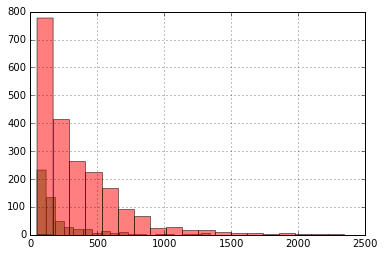

In [385]:
no_filtered_blast_sdf['Pst_E104_v1_h_ctg']['protein_length'].hist(bins=20,alpha=0.5, color='g')
no_filtered_blast_sdf['Pst_E104_v1_p_ctg']['protein_length'].hist(bins=20,alpha=0.5, color='r')

In [400]:
len(no_filtered_blast_sdf['Pst_E104_v1_h_ctg'][no_filtered_blast_sdf['Pst_E104_v1_h_ctg']['exonerate_hit'] == False])/15000

0.023866666666666668

In [44]:
len(nfb_gene_blast_bed_df_filtered[3].unique())

677